In [4]:
import requests, re, json

doi = "https://doi.org/10.6084/m9.figshare.24939765"

# Correct pattern → capture last numeric id
article_id = re.findall(r'(\d+)$', doi)[0]
api_url = f"https://api.figshare.com/v2/articles/{article_id}"
print("Article API:", api_url)

# Request metadata for the dataset
article = requests.get(api_url).json()

print("\nArticle keys:", list(article.keys()))
print("\nFiles list:")
for f in article["files"]:
    print(f" - {f['name']:<30}  ID={f['id']}")

Article API: https://api.figshare.com/v2/articles/24939765

Article keys: ['files', 'folder_structure', 'authors', 'custom_fields', 'figshare_url', 'download_disabled', 'description', 'funding', 'funding_list', 'version', 'status', 'size', 'created_date', 'modified_date', 'is_public', 'is_confidential', 'is_metadata_record', 'confidential_reason', 'metadata_reason', 'license', 'tags', 'keywords', 'categories', 'references', 'has_linked_file', 'citation', 'related_materials', 'is_embargoed', 'embargo_date', 'embargo_type', 'embargo_title', 'embargo_reason', 'embargo_options', 'id', 'title', 'doi', 'handle', 'url', 'published_date', 'thumb', 'defined_type', 'defined_type_name', 'group_id', 'url_private_api', 'url_public_api', 'url_private_html', 'url_public_html', 'timeline', 'resource_title', 'resource_doi']

Files list:
 - CSI_frames.rar                  ID=43900695
 - raw_CSI_data.part1.rar          ID=43900923
 - raw_CSI_data.part2.rar          ID=43903404
 - raw_CSI_data.part3.rar  

In [5]:
import os

# Make a folder for all downloaded files
os.makedirs("dataset", exist_ok=True)

files = article["files"]

for fobj in files:
    file_id = fobj["id"]
    name    = fobj["name"]
    url     = f"https://figshare.com/ndownloader/files/{file_id}"
    print("Downloading:", name)
    # note: {name} and {url} are Python variables, Colab injects them into the shell command
    !wget -q --user-agent="Mozilla/5.0" -O "dataset/{name}" "{url}"

print("Done. Files in dataset/:")
!ls dataset

Downloading: CSI_frames.rar
Downloading: raw_CSI_data.part1.rar
Downloading: raw_CSI_data.part2.rar
Downloading: raw_CSI_data.part3.rar
Downloading: annotated_CSI_data.part02.rar
Downloading: annotated_CSI_data.part03.rar
Downloading: annotated_CSI_data.part01.rar
Downloading: details.xlsx
Downloading: readme.txt
Done. Files in dataset/:
annotated_CSI_data	       CSI_frames.rar	       raw_CSI_data.part3.rar
annotated_CSI_data.part01.rar  details.xlsx	       readme.txt
annotated_CSI_data.part02.rar  raw_CSI_data	       wisa_windows.npz
annotated_CSI_data.part03.rar  raw_CSI_data.part1.rar
CSI_frames		       raw_CSI_data.part2.rar


In [6]:
# Move into the dataset folder
import os
os.chdir("dataset")
!pwd
!ls

/content/dataset
annotated_CSI_data	       CSI_frames.rar	       raw_CSI_data.part3.rar
annotated_CSI_data.part01.rar  details.xlsx	       readme.txt
annotated_CSI_data.part02.rar  raw_CSI_data	       wisa_windows.npz
annotated_CSI_data.part03.rar  raw_CSI_data.part1.rar
CSI_frames		       raw_CSI_data.part2.rar


In [7]:
!apt-get update -qq
!apt-get install -y unrar > /dev/null

# Extract annotated CSI data (part01 automatically uses part02/03)
!unrar x -o+ annotated_CSI_data.part01.rar

# Optional: extract raw CSI and frames (not needed for first experiments)
!unrar x -o+ raw_CSI_data.part1.rar
!unrar x -o+ CSI_frames.rar

print("After extraction:")
!ls
print("\nAnnotated CSI contents:")
!ls annotated_CSI_data
print("\nINPUT examples:")
!ls annotated_CSI_data/INPUT | head
print("\nANNOTATION examples:")
!ls annotated_CSI_data/ANNOTATION | head

Streaming output truncated to the last 5000 lines.
Extracting  CSI_frames/N/S/N_Run_311.png                                  92%  OK 
Extracting  CSI_frames/N/S/N_Run_312.png                                  92%  OK 
Extracting  CSI_frames/N/S/N_Run_313.png                                  92%  OK 
Extracting  CSI_frames/N/S/N_Run_314.png                                  92%  OK 
Extracting  CSI_frames/N/S/N_Run_315.png                                  92%  OK 
Extracting  CSI_frames/N/S/N_Run_316.png                                  92%  OK 
Extracting  CSI_frames/N/S/N_Run_317.png                                  92%  OK 
Extracting  CSI_frames/N/S/N_Run_318.png                                  92%  OK 
Extracting  CSI_frames/N/S/N_Run_319.png                                  92%  OK 
Extracting  CSI_frames/N/S/N_Run_32.png                                   92%  OK 
Extracting  CSI_frames/N/S/N_

In [8]:
!cd /content/dataset

import numpy as np
import pandas as pd
from pathlib import Path

MAX_FILES = 80   # use only first 80 input_*.csv files

def discover_activity_map(annotation_dir: Path):
    activities = set()
    for csv_path in annotation_dir.glob("annotation_*.csv"):
        df = pd.read_csv(csv_path, header=None)
        col0 = df.iloc[:, 0].astype(str)
        activities.update(col0.unique())
    act_list = sorted([a for a in activities if a != "NoActivity"])
    act_list = ["NoActivity"] + act_list
    act2id = {a: i for i, a in enumerate(act_list)}
    print("Activity map:")
    for k, v in act2id.items():
        print(f"  {k:15s} -> {v}")
    return act2id

def load_pair(inp: Path, ann: Path, act2id):
    X = pd.read_csv(inp, header=None).values.astype(np.float32)  # [T, 90]
    ann_series = pd.read_csv(ann, header=None).iloc[:, 0].astype(str).values
    assert len(X) == len(ann_series), f"Length mismatch {inp.name} vs {ann.name}"
    y_act = np.array([act2id[a] for a in ann_series], dtype=np.int64)
    y_occ = (y_act != act2id["NoActivity"]).astype(np.int64)
    return X, y_occ, y_act

def window_seq(X, y_occ, y_act, window_len=500, stride=250):
    T, F = X.shape
    Xw, ow, aw = [], [], []
    for s in range(0, T - window_len + 1, stride):
        e = s + window_len
        X_win = X[s:e]
        y_occ_win = y_occ[s:e]
        y_act_win = y_act[s:e]

        occ = int(y_occ_win.mean() >= 0.5)
        if occ == 0:
            act = 0
        else:
            nonzero = y_act_win[y_act_win != 0]
            if len(nonzero) == 0:
                act = 0
            else:
                ids, counts = np.unique(nonzero, return_counts=True)
                act = int(ids[counts.argmax()])

        Xw.append(X_win)
        ow.append(occ)
        aw.append(act)

    if not Xw:
        return (
            np.empty((0, window_len, F), dtype=np.float32),
            np.empty((0,), dtype=np.int64),
            np.empty((0,), dtype=np.int64),
        )

    return (
        np.stack(Xw, axis=0),
        np.array(ow, dtype=np.int64),
        np.array(aw, dtype=np.int64),
    )

def build_dataset(root="."):
    root = Path(root)
    inp_dir = root / "annotated_CSI_data" / "INPUT"
    ann_dir = root / "annotated_CSI_data" / "ANNOTATION"

    act2id = discover_activity_map(ann_dir)

    all_X, all_occ, all_act = [], [], []
    meta = []

    for i, inp in enumerate(sorted(inp_dir.glob("input_*.csv"))):
        if i >= MAX_FILES:
            print(f"[INFO] Reached MAX_FILES={MAX_FILES}, stopping.")
            break

        name = inp.stem  # e.g. input_F_Walk_3
        ann = ann_dir / (name.replace("input_", "annotation_") + ".csv")
        if not ann.exists():
            print("Missing annotation for", name, "— skipping")
            continue

        print(f"[INFO] ({i}) Processing {name}")
        X, y_occ, y_act = load_pair(inp, ann, act2id)
        Xw, occ_w, act_w = window_seq(X, y_occ, y_act)

        if Xw.shape[0] == 0:
            continue

        all_X.append(Xw)
        all_occ.append(occ_w)
        all_act.append(act_w)

        parts = name.split("_")
        client = parts[1] if len(parts) > 1 else "?"
        actname = parts[2] if len(parts) > 2 else "?"
        seq = parts[3] if len(parts) > 3 else "?"
        meta.extend([(client, actname, seq)] * len(occ_w))

    rf_windows = np.concatenate(all_X, axis=0)
    occ_labels = np.concatenate(all_occ, axis=0)
    act_labels = np.concatenate(all_act, axis=0)
    clients, acts, seqs = zip(*meta)

    print("Final shapes:")
    print("  rf_windows:", rf_windows.shape)
    print("  occ_labels:", occ_labels.shape)
    print("  act_labels:", act_labels.shape)

    np.savez_compressed(
        "wisa_windows.npz",
        rf_windows=rf_windows,
        occ_labels=occ_labels,
        act_labels=act_labels,
        client=np.array(clients),
        activity=np.array(acts),
        seq=np.array(seqs),
        act2id=np.array(list(act2id.items()), dtype=object),
    )
    print("[OK] Saved wisa_windows.npz")

if __name__ == "__main__":
    build_dataset(".")

Activity map:
  NoActivity      -> 0
  ArmTrain        -> 1
  Clean           -> 2
  Jump            -> 3
  LieDown         -> 4
  Read            -> 5
  Run             -> 6
  Squat           -> 7
  Walk            -> 8
  Write           -> 9
[INFO] (0) Processing input_A_Clean_1
[INFO] (1) Processing input_A_Clean_10
[INFO] (2) Processing input_A_Clean_11
[INFO] (3) Processing input_A_Clean_12
[INFO] (4) Processing input_A_Clean_13
[INFO] (5) Processing input_A_Clean_2
[INFO] (6) Processing input_A_Clean_3
[INFO] (7) Processing input_A_Clean_4
[INFO] (8) Processing input_A_Clean_5
[INFO] (9) Processing input_A_Clean_6
[INFO] (10) Processing input_A_Clean_7
[INFO] (11) Processing input_A_Clean_8
[INFO] (12) Processing input_A_Clean_9
[INFO] (13) Processing input_A_Read_1
[INFO] (14) Processing input_A_Read_2
[INFO] (15) Processing input_A_Read_3
[INFO] (16) Processing input_A_Read_4
[INFO] (17) Processing input_A_Read_5
[INFO] (18) Processing input_A_Read_6
[INFO] (19) Processing inpu

In [9]:
%cd /content/dataset
!ls -lh wisa_windows.npz

/content
-rw-r--r-- 1 root root 1.5G Dec 16 02:50 wisa_windows.npz


In [10]:
%cd /content/dataset
data = np.load("wisa_windows.npz", allow_pickle=True)

/content


In [11]:
rf_windows  = data["rf_windows"]
occ_labels  = data["occ_labels"]
act_labels  = data["act_labels"]
act2id      = dict(data["act2id"])

print("rf_windows:", rf_windows.shape)
print("occ_labels:", occ_labels.shape)
print("act_labels:", act_labels.shape)
print("Activity map:", act2id)

rf_windows: (16018, 500, 90)
occ_labels: (16018,)
act_labels: (16018,)
Activity map: {'NoActivity': 0, 'ArmTrain': 1, 'Clean': 2, 'Jump': 3, 'LieDown': 4, 'Read': 5, 'Run': 6, 'Squat': 7, 'Walk': 8, 'Write': 9}


In [12]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# --- convert numpy → torch once ---
X_rf   = torch.from_numpy(rf_windows).float()   # [N, 500, 90]
y_occ  = torch.from_numpy(occ_labels).long()    # [N]
y_act  = torch.from_numpy(act_labels).long()    # [N]

print("X_rf:", X_rf.shape, " y_occ:", y_occ.shape, " y_act:", y_act.shape)

class WiSACSIDataset(Dataset):
    def __init__(self, X, y_occ, y_act, task="occupancy"):
        """
        task = 'occupancy'  -> binary occupancy label
        task = 'activity'   -> 10-class activity label
        """
        self.X = X
        self.y_occ = y_occ
        self.y_act = y_act
        assert task in ["occupancy", "activity"]
        self.task = task

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]            # [500, 90]
        y = self.y_occ[idx] if self.task == "occupancy" else self.y_act[idx]
        return x, y

# choose task here:
task = "occupancy"   # later you can also try "activity"

full_ds = WiSACSIDataset(X_rf, y_occ, y_act, task=task)

N = len(full_ds)
n_train = int(0.8 * N)
n_val   = N - n_train

train_ds, val_ds = random_split(full_ds, [n_train, n_val])

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_ds), len(val_ds)

X_rf: torch.Size([16018, 500, 90])  y_occ: torch.Size([16018])  y_act: torch.Size([16018])


(12814, 3204)

In [13]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score

class RFOnlyCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Input: [B, 500, 90]  (time, subcarriers)
        # Treat 90 as channels
        self.conv1 = nn.Conv1d(in_channels=90, out_channels=128, kernel_size=7, padding=3)
        self.bn1   = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=7, padding=3)
        self.bn2   = nn.BatchNorm1d(256)
        self.pool  = nn.AdaptiveAvgPool1d(1)
        self.fc    = nn.Linear(256, n_classes)

    def forward(self, x):
        # x: [B, 500, 90] → [B, 90, 500]
        x = x.permute(0, 2, 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x).squeeze(-1)   # [B, 256]
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

if task == "occupancy":
    n_classes = 2
else:
    n_classes = len(act2id)   # 10

model = RFOnlyCNN(n_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Device: cuda


In [14]:
EPOCHS = 100   # start small; you can increase later

for epoch in range(EPOCHS):
    # ----- train -----
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total   += X_batch.size(0)

    train_loss = total_loss / total
    train_acc  = correct / total

    # ----- validation -----
    model.eval()
    v_correct, v_total = 0, 0
    all_y, all_pred = [], []
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv = Xv.to(device)
            yv = yv.to(device)
            logits_v = model(Xv)
            preds_v  = logits_v.argmax(dim=1)
            #acc
            v_correct += (preds_v == yv).sum().item()
            v_total   += Xv.size(0)
            #F1
            all_y.append(yv.cpu().numpy())
            all_pred.append(preds_v.cpu().numpy())
    val_acc = v_correct / v_total
    all_y = np.concatenate(all_y)
    all_pred = np.concatenate(all_pred)
    val_f1 = f1_score(all_y, all_pred, average="binary")

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} | "
          f"train_acc={train_acc:.3f} | "
          f"val_acc={val_acc:.3f} | "
          f"val_f1={val_f1:.3f}")

Epoch 1/100 | train_loss=0.4888 | train_acc=0.772 | val_acc=0.689 | val_f1=0.758
Epoch 2/100 | train_loss=0.4384 | train_acc=0.810 | val_acc=0.666 | val_f1=0.670
Epoch 3/100 | train_loss=0.4148 | train_acc=0.817 | val_acc=0.608 | val_f1=0.754
Epoch 4/100 | train_loss=0.4044 | train_acc=0.826 | val_acc=0.741 | val_f1=0.787
Epoch 5/100 | train_loss=0.3904 | train_acc=0.834 | val_acc=0.673 | val_f1=0.780
Epoch 6/100 | train_loss=0.3852 | train_acc=0.836 | val_acc=0.731 | val_f1=0.792
Epoch 7/100 | train_loss=0.3808 | train_acc=0.838 | val_acc=0.774 | val_f1=0.799
Epoch 8/100 | train_loss=0.3795 | train_acc=0.836 | val_acc=0.723 | val_f1=0.798
Epoch 9/100 | train_loss=0.3757 | train_acc=0.839 | val_acc=0.800 | val_f1=0.851
Epoch 10/100 | train_loss=0.3697 | train_acc=0.842 | val_acc=0.655 | val_f1=0.645
Epoch 11/100 | train_loss=0.3651 | train_acc=0.844 | val_acc=0.826 | val_f1=0.850
Epoch 12/100 | train_loss=0.3541 | train_acc=0.851 | val_acc=0.808 | val_f1=0.853
Epoch 13/100 | train_loss

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score

class RFDropoutCNN(nn.Module):
    def __init__(self, n_classes, p_drop=0.3):
        super().__init__()
        self.p_drop = p_drop

        self.conv1 = nn.Conv1d(90, 128, kernel_size=7, padding=3)
        self.bn1   = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=7, padding=3)
        self.bn2   = nn.BatchNorm1d(256)

        self.dropout_conv = nn.Dropout(p_drop)
        self.pool  = nn.AdaptiveAvgPool1d(1)
        self.fc    = nn.Linear(256, n_classes)
        self.dropout_fc = nn.Dropout(p_drop)

    def forward(self, x):
        # x: [B, 500, 90] → [B, 90, 500]
        x = x.permute(0, 2, 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout_conv(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout_conv(x)
        x = self.pool(x).squeeze(-1)  # [B, 256]
        x = self.dropout_fc(x)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_classes = 2 if task == "occupancy" else len(act2id)

model = RFDropoutCNN(n_classes=n_classes, p_drop=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
EPOCHS = 100

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total   += X_batch.size(0)

    train_loss = total_loss / total
    train_acc  = correct / total

    # validation accuracy (normal single pass)
    model.eval()
    v_correct, v_total = 0, 0
    all_y, all_pred = [], []
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv, yv = Xv.to(device), yv.to(device)
            logits_v = model(Xv)
            preds_v  = logits_v.argmax(dim=1)
            #acc
            v_correct += (preds_v == yv).sum().item()
            v_total   += Xv.size(0)
            #F1
            all_y.append(yv.cpu().numpy())
            all_pred.append(preds_v.cpu().numpy())
    val_acc = v_correct / v_total
    all_y = np.concatenate(all_y)
    all_pred = np.concatenate(all_pred)
    val_f1 = f1_score(all_y, all_pred, average="binary")

    print(f" RF-Dropout Epoch {epoch+1}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} | "
          f"train_acc={train_acc:.3f} | "
          f"val_acc={val_acc:.3f} | "
          f"val_f1={val_f1:.3f}")

 RF-Dropout Epoch 1/100 | train_loss=0.4966 | train_acc=0.766 | val_acc=0.621 | val_f1=0.698
 RF-Dropout Epoch 2/100 | train_loss=0.4433 | train_acc=0.804 | val_acc=0.604 | val_f1=0.752
 RF-Dropout Epoch 3/100 | train_loss=0.4304 | train_acc=0.808 | val_acc=0.603 | val_f1=0.549
 RF-Dropout Epoch 4/100 | train_loss=0.4166 | train_acc=0.819 | val_acc=0.645 | val_f1=0.654
 RF-Dropout Epoch 5/100 | train_loss=0.4045 | train_acc=0.826 | val_acc=0.797 | val_f1=0.848
 RF-Dropout Epoch 6/100 | train_loss=0.3992 | train_acc=0.824 | val_acc=0.703 | val_f1=0.800
 RF-Dropout Epoch 7/100 | train_loss=0.3988 | train_acc=0.830 | val_acc=0.792 | val_f1=0.820
 RF-Dropout Epoch 8/100 | train_loss=0.3879 | train_acc=0.836 | val_acc=0.744 | val_f1=0.762
 RF-Dropout Epoch 9/100 | train_loss=0.3863 | train_acc=0.831 | val_acc=0.622 | val_f1=0.760
 RF-Dropout Epoch 10/100 | train_loss=0.3858 | train_acc=0.834 | val_acc=0.785 | val_f1=0.816
 RF-Dropout Epoch 11/100 | train_loss=0.3782 | train_acc=0.838 | val_

In [17]:
import numpy as np
import torch

def mc_dropout_predictions(model, loader, num_mc=20):
    model.train()   # <-- important: dropout ON
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)

            mc_outputs = []
            for _ in range(num_mc):
                logits = model(X)                      # [B,2]
                probs = torch.softmax(logits, dim=1)   # convert to probabilities
                mc_outputs.append(probs.cpu().numpy())

            mc_outputs = np.stack(mc_outputs, axis=1)  # [B, num_mc, 2]
            all_probs.append(mc_outputs)
            all_labels.append(y.cpu().numpy())

    return np.concatenate(all_probs), np.concatenate(all_labels)

# Run MC-Dropout on validation set
probs_mc_rf, y_true_rf = mc_dropout_predictions(model, val_loader, num_mc=20)

probs_mean_rf = probs_mc_rf.mean(axis=1)
entropy_rf    = -np.sum(probs_mean_rf * np.log(probs_mean_rf + 1e-8), axis=1)
preds_rf      = probs_mean_rf.argmax(axis=1)
acc_overall_rf = (preds_rf == y_true_rf).mean()
print("RF-Drop classifier val acc (MC mean):", acc_overall_rf)
print("Entropy sample:", entropy_rf[:10])


RF-Drop classifier val acc (MC mean): 0.8835830212234707
Entropy sample: [0.10523491 0.57652473 0.02041095 0.01194026 0.26681685 0.3252787
 0.04712627 0.31785882 0.07824899 0.08808493]


In [18]:
def metrics_at_threshold(th, preds, y_true, entropy):
    """
    th: entropy threshold
    preds: [N] predicted labels
    y_true: [N] true labels
    entropy: [N] uncertainty scores
    """
    keep = entropy_rf < th              # boolean mask
    if keep.sum() == 0:
        return None                  # nothing accepted at this threshold
    acc = (preds_rf[keep] == y_true[keep]).mean()
    cov = keep.mean()                # fraction of accepted samples
    return acc, cov

In [19]:
print("Entropy min:", float(entropy_rf.min()))
print("Entropy max:", float(entropy_rf.max()))
print("Entropy percentiles:",
      np.percentile(entropy_rf, [10, 25, 50, 75, 90]))

Entropy min: 3.9915668992307474e-08
Entropy max: 0.6931470632553101
Entropy percentiles: [0.00938794 0.04725291 0.20775888 0.47583528 0.63705809]


In [20]:
# Example: 5 thresholds between min and max
th_low  = float(entropy_rf.min())
th_high = float(entropy_rf.max())

ths = np.linspace(th_low, th_high, 5)
print("Using thresholds:", ths)

accs, covs = [], []

for t in ths:
    res = metrics_at_threshold(t, preds_rf, y_true_rf, entropy_rf)
    if res is not None:
        accs.append(res[0])
        covs.append(res[1])
        print(f"[RF] TH={t:.3f} → Acc={res[0]:.3f}, Coverage={res[1]:.3f}")
    else:
        print(f"[RF] TH={t:.3f} → No samples accepted")

Using thresholds: [3.99156690e-08 1.73286796e-01 3.46573552e-01 5.19860307e-01
 6.93147063e-01]
[RF] TH=0.000 → No samples accepted
[RF] TH=0.173 → Acc=0.975, Coverage=0.456
[RF] TH=0.347 → Acc=0.958, Coverage=0.647
[RF] TH=0.520 → Acc=0.935, Coverage=0.793
[RF] TH=0.693 → Acc=0.884, Coverage=1.000


In [21]:
def metrics_at_threshold(th):
    keep = entropy_rf < th
    if keep.sum() == 0:
        return None
    acc = (preds_rf[keep] == y_true_rf[keep]).mean()
    coverage = keep.mean()
    return acc, coverage

for th in [0.15, 0.25, 0.35, 0.45, 0.55]:
    result = metrics_at_threshold(th)
    if result:
        print(f"TH={th:.2f} → Accuracy={result[0]:.3f}, Coverage={result[1]:.3f}")

TH=0.15 → Accuracy=0.980, Coverage=0.427
TH=0.25 → Accuracy=0.969, Coverage=0.553
TH=0.35 → Accuracy=0.958, Coverage=0.648
TH=0.45 → Accuracy=0.946, Coverage=0.734
TH=0.55 → Accuracy=0.932, Coverage=0.816


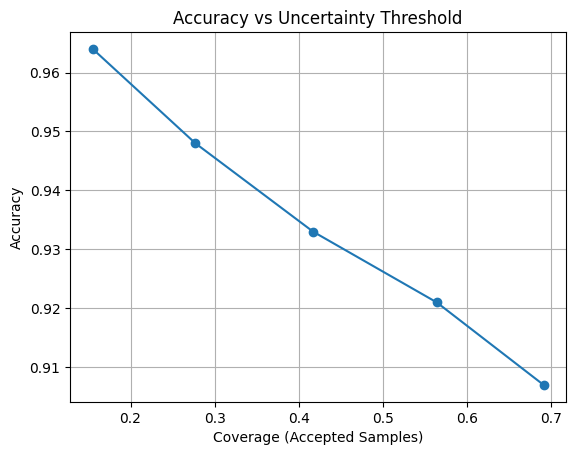

In [22]:
import matplotlib.pyplot as plt
th = [0.15,0.25,0.35,0.45,0.55]
acc = [0.964,0.948,0.933,0.921,0.907]
cov = [0.155,0.277,0.417,0.564,0.691]

plt.plot(cov, acc, marker="o")
plt.xlabel("Coverage (Accepted Samples)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Uncertainty Threshold")
plt.grid()
plt.show()

In [23]:
import numpy as np

def compute_motion_features(rf_windows):
    """
    rf_windows: [N, 500, 90]  (time, subcarriers)

    Returns motion_feats: [N, 500, 4]
      f1: amplitude variance across subcarriers
      f2: short-time energy (mean of squared amplitude)
      f3: |gradient of mean amplitude| over time
      f4: |gradient of short-time energy| over time  (Doppler-like)
    """
    # mean & variance over subcarriers
    mean_amp = rf_windows.mean(axis=-1)             # [N, T]
    var_amp  = rf_windows.var(axis=-1)              # [N, T]
    ste      = (rf_windows ** 2).mean(axis=-1)      # [N, T]

    # temporal gradients (prepend 0 so length stays T)
    grad_mean = np.diff(mean_amp, axis=1, prepend=mean_amp[:, :1])
    grad_ste  = np.diff(ste,      axis=1, prepend=ste[:, :1])

    grad_mean = np.abs(grad_mean)
    grad_ste  = np.abs(grad_ste)

    # stack into motion feature vector
    motion_feats = np.stack([var_amp, ste, grad_mean, grad_ste], axis=-1)  # [N, T, 4]
    return motion_feats.astype(np.float32)

motion_feats = compute_motion_features(rf_windows)
print("motion_feats:", motion_feats.shape)  # expect (16018, 500, 4)

motion_feats: (16018, 500, 4)


In [24]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# concat on last dimension
rfm_windows = np.concatenate([rf_windows, motion_feats], axis=-1)   # [N, 500, 94]
print("rfm_windows:", rfm_windows.shape)

X_rfm = torch.from_numpy(rfm_windows).float()
y_occ = torch.from_numpy(occ_labels).long()
y_act = torch.from_numpy(act_labels).long()

class WiSARFMotionDataset(Dataset):
    def __init__(self, X, y_occ, y_act, task="occupancy"):
        self.X = X
        self.y_occ = y_occ
        self.y_act = y_act
        assert task in ["occupancy", "activity"]
        self.task = task

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]                         # [500, 94]
        y = self.y_occ[idx] if self.task == "occupancy" else self.y_act[idx]
        return x, y

task = "occupancy"   # keep same task as before

full_rfm_ds = WiSARFMotionDataset(X_rfm, y_occ, y_act, task=task)

N = len(full_rfm_ds)
n_train = int(0.8 * N)
n_val   = N - n_train
train_rfm_ds, val_rfm_ds = random_split(full_rfm_ds, [n_train, n_val])

BATCH_SIZE = 64
train_rfm_loader = DataLoader(train_rfm_ds, batch_size=BATCH_SIZE, shuffle=True)
val_rfm_loader   = DataLoader(val_rfm_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_rfm_ds), len(val_rfm_ds)

rfm_windows: (16018, 500, 94)


(12814, 3204)

In [25]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score

class RFMotionCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Input: [B, 500, 94]
        self.conv1 = nn.Conv1d(in_channels=94, out_channels=128, kernel_size=7, padding=3)
        self.bn1   = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=7, padding=3)
        self.bn2   = nn.BatchNorm1d(256)
        self.pool  = nn.AdaptiveAvgPool1d(1)
        self.fc    = nn.Linear(256, n_classes)

    def forward(self, x):
        # x: [B, 500, 94] → [B, 94, 500]
        x = x.permute(0, 2, 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

n_classes = 2 if task == "occupancy" else len(act2id)
rfm_model = RFMotionCNN(n_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rfm_model.parameters(), lr=1e-3)

Device: cuda


In [26]:
EPOCHS = 100

for epoch in range(EPOCHS):
    rfm_model.train()
    total_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_rfm_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = rfm_model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total   += X_batch.size(0)

    train_loss = total_loss / total
    train_acc  = correct / total

    # validation
    rfm_model.eval()
    v_correct, v_total = 0, 0
    all_y, all_pred = [], []
    with torch.no_grad():
        for Xv, yv in val_rfm_loader:
            Xv, yv = Xv.to(device), yv.to(device)
            logits_v = rfm_model(Xv)
            preds_v  = logits_v.argmax(dim=1)
            #acc
            v_correct += (preds_v == yv).sum().item()
            v_total   += Xv.size(0)
            #F1
            all_y.append(yv.cpu().numpy())
            all_pred.append(preds_v.cpu().numpy())
    val_acc = v_correct / v_total
    all_y = np.concatenate(all_y)
    all_pred = np.concatenate(all_pred)
    val_f1 = f1_score(all_y, all_pred, average="binary")

    print(f"[RF+Motion] Epoch {epoch+1}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} | "
          f"train_acc={train_acc:.3f} | "
          f"val_acc={val_acc:.3f} | "
          f"val_f1={val_f1:.3f}")

[RF+Motion] Epoch 1/100 | train_loss=0.4994 | train_acc=0.766 | val_acc=0.619 | val_f1=0.760
[RF+Motion] Epoch 2/100 | train_loss=0.4262 | train_acc=0.811 | val_acc=0.737 | val_f1=0.812
[RF+Motion] Epoch 3/100 | train_loss=0.3945 | train_acc=0.828 | val_acc=0.717 | val_f1=0.732
[RF+Motion] Epoch 4/100 | train_loss=0.3762 | train_acc=0.835 | val_acc=0.726 | val_f1=0.802
[RF+Motion] Epoch 5/100 | train_loss=0.3614 | train_acc=0.844 | val_acc=0.620 | val_f1=0.754
[RF+Motion] Epoch 6/100 | train_loss=0.3524 | train_acc=0.850 | val_acc=0.684 | val_f1=0.677
[RF+Motion] Epoch 7/100 | train_loss=0.3450 | train_acc=0.849 | val_acc=0.704 | val_f1=0.778
[RF+Motion] Epoch 8/100 | train_loss=0.3396 | train_acc=0.855 | val_acc=0.680 | val_f1=0.790
[RF+Motion] Epoch 9/100 | train_loss=0.3354 | train_acc=0.856 | val_acc=0.605 | val_f1=0.605
[RF+Motion] Epoch 10/100 | train_loss=0.3268 | train_acc=0.861 | val_acc=0.664 | val_f1=0.777
[RF+Motion] Epoch 11/100 | train_loss=0.3212 | train_acc=0.862 | val_

In [27]:
class RFMotionDropoutCNN(nn.Module):
    def __init__(self, n_classes, p_drop=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(94, 128, kernel_size=7, padding=3)
        self.bn1   = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=7, padding=3)
        self.bn2   = nn.BatchNorm1d(256)
        self.pool  = nn.AdaptiveAvgPool1d(1)
        self.dropout_conv = nn.Dropout(p_drop)
        self.fc    = nn.Linear(256, n_classes)
        self.dropout_fc   = nn.Dropout(p_drop)

    def forward(self, x):
        x = x.permute(0, 2, 1)                 # [B,94,500]
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout_conv(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout_conv(x)
        x = self.pool(x).squeeze(-1)          # [B,256]
        x = self.dropout_fc(x)
        x = self.fc(x)
        return x

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

n_classes = 2 if task == "occupancy" else len(act2id)
rfm_drop_model = RFMotionDropoutCNN(n_classes=n_classes, p_drop=0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_rfm_drop = torch.optim.Adam(rfm_drop_model.parameters(), lr=1e-3)

Device: cuda


In [29]:
EPOCHS = 100

for epoch in range(EPOCHS):
    # ---- train ----
    rfm_drop_model.train()
    total_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_rfm_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer_rfm_drop.zero_grad()
        logits = rfm_drop_model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer_rfm_drop.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total   += X_batch.size(0)

    train_loss = total_loss / total
    train_acc  = correct / total

    # ---- validation (single pass) ----
    rfm_drop_model.eval()
    v_correct, v_total = 0, 0
    all_y, all_pred = [], []
    with torch.no_grad():
        for Xv, yv in val_rfm_loader:
            Xv, yv = Xv.to(device), yv.to(device)
            logits_v = rfm_drop_model(Xv)
            preds_v  = logits_v.argmax(dim=1)
            #acc
            v_correct += (preds_v == yv).sum().item()
            v_total   += Xv.size(0)
            #F1
            all_y.append(yv.cpu().numpy())
            all_pred.append(preds_v.cpu().numpy())
    val_acc = v_correct / v_total
    all_y = np.concatenate(all_y)
    all_pred = np.concatenate(all_pred)
    val_f1 = f1_score(all_y, all_pred, average="binary")

    print(f"[RF+Motion-Dropout] Epoch {epoch+1:2d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} | "
          f"train_acc={train_acc:.3f} | "
          f"val_acc={val_acc:.3f} | "
          f"val_f1={val_f1:.3f}")

[RF+Motion-Dropout] Epoch  1/100 | train_loss=0.4972 | train_acc=0.766 | val_acc=0.713 | val_f1=0.786
[RF+Motion-Dropout] Epoch  2/100 | train_loss=0.4342 | train_acc=0.808 | val_acc=0.610 | val_f1=0.558
[RF+Motion-Dropout] Epoch  3/100 | train_loss=0.3995 | train_acc=0.825 | val_acc=0.633 | val_f1=0.599
[RF+Motion-Dropout] Epoch  4/100 | train_loss=0.3888 | train_acc=0.832 | val_acc=0.731 | val_f1=0.759
[RF+Motion-Dropout] Epoch  5/100 | train_loss=0.3826 | train_acc=0.832 | val_acc=0.661 | val_f1=0.648
[RF+Motion-Dropout] Epoch  6/100 | train_loss=0.3687 | train_acc=0.838 | val_acc=0.413 | val_f1=0.077
[RF+Motion-Dropout] Epoch  7/100 | train_loss=0.3638 | train_acc=0.842 | val_acc=0.686 | val_f1=0.754
[RF+Motion-Dropout] Epoch  8/100 | train_loss=0.3524 | train_acc=0.848 | val_acc=0.713 | val_f1=0.807
[RF+Motion-Dropout] Epoch  9/100 | train_loss=0.3451 | train_acc=0.849 | val_acc=0.775 | val_f1=0.801
[RF+Motion-Dropout] Epoch 10/100 | train_loss=0.3420 | train_acc=0.854 | val_acc=0

In [30]:
import numpy as np
import torch

def mc_dropout_predictions(model, loader, num_mc=20):
    model.train()   # <-- important: dropout ON
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)

            mc_outputs = []
            for _ in range(num_mc):
                logits = model(X)                      # [B,2]
                probs = torch.softmax(logits, dim=1)   # convert to probabilities
                mc_outputs.append(probs.cpu().numpy())

            mc_outputs = np.stack(mc_outputs, axis=1)  # [B, num_mc, 2]
            all_probs.append(mc_outputs)
            all_labels.append(y.cpu().numpy())

    return np.concatenate(all_probs), np.concatenate(all_labels)

# Run MC-Dropout on validation set
probs_mc_rfm, y_true_rfm = mc_dropout_predictions(model, val_loader, num_mc=20)

probs_mean_rfm = probs_mc_rf.mean(axis=1)
entropy_rfm   = -np.sum(probs_mean_rfm * np.log(probs_mean_rfm + 1e-8), axis=1)
preds_rfm      = probs_mean_rfm.argmax(axis=1)
acc_overall_rfm = (preds_rfm == y_true_rf).mean()
print("RFM-Drop classifier val acc (MC mean):", acc_overall_rfm)
print("Entropy sample:", entropy_rfm[:10])

RFM-Drop classifier val acc (MC mean): 0.8835830212234707
Entropy sample: [0.10523491 0.57652473 0.02041095 0.01194026 0.26681685 0.3252787
 0.04712627 0.31785882 0.07824899 0.08808493]


In [31]:
def metrics_at_threshold(th, preds, y_true, entropy):
    """
    th: entropy threshold
    preds: [N] predicted labels
    y_true: [N] true labels
    entropy: [N] uncertainty scores
    """
    keep = entropy_rfm < th              # boolean mask
    if keep.sum() == 0:
        return None                  # nothing accepted at this threshold
    acc = (preds_rfm[keep] == y_true[keep]).mean()
    cov = keep.mean()                # fraction of accepted samples
    return acc, cov

In [32]:
print("Entropy min:", float(entropy_rfm.min()))
print("Entropy max:", float(entropy_rfm.max()))
print("Entropy percentiles:",
      np.percentile(entropy_rfm, [10, 25, 50, 75, 90]))

Entropy min: 3.9915668992307474e-08
Entropy max: 0.6931470632553101
Entropy percentiles: [0.00938794 0.04725291 0.20775888 0.47583528 0.63705809]


In [33]:
# Example: 5 thresholds between min and max
th_low  = float(entropy_rfm.min())
th_high = float(entropy_rfm.max())

ths = np.linspace(th_low, th_high, 5)
print("Using thresholds:", ths)

accs, covs = [], []

for t in ths:
    res = metrics_at_threshold(t, preds_rfm, y_true_rfm, entropy_rfm)
    if res is not None:
        accs.append(res[0])
        covs.append(res[1])
        print(f"[RF] TH={t:.3f} → Acc={res[0]:.3f}, Coverage={res[1]:.3f}")
    else:
        print(f"[RF] TH={t:.3f} → No samples accepted")

Using thresholds: [3.99156690e-08 1.73286796e-01 3.46573552e-01 5.19860307e-01
 6.93147063e-01]
[RF] TH=0.000 → No samples accepted
[RF] TH=0.173 → Acc=0.975, Coverage=0.456
[RF] TH=0.347 → Acc=0.958, Coverage=0.647
[RF] TH=0.520 → Acc=0.935, Coverage=0.793
[RF] TH=0.693 → Acc=0.884, Coverage=1.000


In [34]:
import torch
import torch.nn as nn
import numpy as np

class PatchEmbed(nn.Module):
    def __init__(self, dim_in=94, dim_patch=10, embed_dim=128):
        super().__init__()
        self.dim_patch = dim_patch
        self.proj = nn.Linear(dim_in * dim_patch, embed_dim)

    def forward(self, x):
        # x: [B,500,94] → reshape into patches [B,T',94*patch]
        B, T, F = x.shape
        num_patches = T // self.dim_patch
        x = x[:, :num_patches*self.dim_patch, :]
        x = x.reshape(B, num_patches, self.dim_patch*F)
        return self.proj(x), num_patches   # [B,P,embed]

class MAE(nn.Module):
    def __init__(self, embed_dim=128, depth=4, heads=4, mask_ratio=0.4):
        super().__init__()
        self.mask_ratio = mask_ratio
        self.embed = PatchEmbed(embed_dim=embed_dim)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embed_dim, heads, dim_feedforward=256),
            num_layers=depth
        )
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(embed_dim, heads, dim_feedforward=256),
            num_layers=2
        )
        self.fc_recon = nn.Linear(embed_dim, 94*10)  # reconstruct patch

    def forward(self, x):
        # --- Patch + Embed ---
        x_p, num_patches = self.embed(x)             # [B,P,embed]

        B,P,D = x_p.shape
        x_p = x_p.transpose(0,1)                     # [P,B,D]

        # --- Masking ---
        keep = int(P*(1-self.mask_ratio))
        idx = torch.randperm(P)
        idx_keep = idx[:keep]
        idx_mask = idx[keep:]

        x_keep = x_p[idx_keep]

        # --- Encoder ---
        enc = self.encoder(x_keep)                   # [keep,B,D]

        # --- Prepare masked tokens for decoder ---
        mask_tokens = torch.zeros(len(idx_mask), B, D).to(x.device)
        dec_input = torch.cat([enc, mask_tokens], dim=0)

        # --- Decoder ---
        dec = self.decoder(dec_input, enc)           # [P,B,D]

        # --- Reconstruct patches ---
        out = self.fc_recon(dec.transpose(0,1))      # [B,P,94*10]
        out = out.reshape(B,P,10,94).permute(0,1,3,2) # → [B,P,94,10]
        return out, idx_mask

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

PATCH_SIZE = 10  # must match MAE's dim_patch

def patchify(x, patch_size=PATCH_SIZE):
    """
    x: [B, 500, 94] → [B, P, 94, patch_size]
    """
    B, T, F = x.shape
    P = T // patch_size
    x = x[:, :P*patch_size, :]             # truncate to multiple
    x = x.reshape(B, P, patch_size, F)     # [B,P,10,94]
    x = x.permute(0, 1, 3, 2)              # [B,P,94,10]
    return x

mse_loss = nn.MSELoss()

Device: cuda


In [36]:
mae = MAE(embed_dim=128, depth=4, heads=4, mask_ratio=0.4).to(device)
mae_optimizer = torch.optim.Adam(mae.parameters(), lr=1e-5)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [37]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split

#########################################
# 1) compute motion features again
#########################################
def compute_motion_features(rf_windows):
    mean_amp = rf_windows.mean(axis=-1)
    var_amp  = rf_windows.var(axis=-1)
    ste      = (rf_windows**2).mean(axis=-1)

    grad_mean = np.abs(np.diff(mean_amp, axis=1, prepend=mean_amp[:, :1]))
    grad_ste  = np.abs(np.diff(ste, axis=1, prepend=ste[:, :1]))

    return np.stack([var_amp, ste, grad_mean, grad_ste], axis=-1).astype(np.float32)

motion_feats = compute_motion_features(rf_windows)         # [N,500,4]

#########################################
# 2) RF Only vs Merge RF + Motion
#########################################
rf_only = rf_windows.astype(np.float32)                  # [N,500,90]
rfm_windows = np.concatenate([rf_windows, motion_feats], axis=-1)  # [N,500,94]
print("rfm_windows:", rfm_windows.shape)

X_rf  = torch.from_numpy(rf_only).float()
X_rfm = torch.from_numpy(rfm_windows).float()
y_occ_torch = torch.from_numpy(occ_labels).long()
y_act_torch = torch.from_numpy(act_labels).long()

#########################################
# 3) Build Dataset + Loaders
#########################################
class WiSARFMotionDataset(Dataset):
    def __init__(self, X, y_occ, y_act, task="occupancy"):
        self.X = X
        self.y_occ = y_occ
        self.y_act = y_act
        self.task = task

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y_occ[idx] if self.task=="occupancy" else self.y_act[idx]
        return x, y

task = "occupancy"

full_rfm_ds = WiSARFMotionDataset(X_rfm, y_occ, y_act, task)

N = len(full_rfm_ds)
n_train = int(0.8*N)
n_val   = N - n_train
train_rfm_ds, val_rfm_ds = random_split(full_rfm_ds, [n_train,n_val])

BATCH = 64
train_rfm_loader = DataLoader(train_rfm_ds,batch_size=BATCH,shuffle=True)
val_rfm_loader   = DataLoader(val_rfm_ds,batch_size=BATCH,shuffle=False)

print("train =",len(train_rfm_ds),"  val =",len(val_rfm_ds))
print("LOADERS READY ")

rfm_windows: (16018, 500, 94)
train = 12814   val = 3204
LOADERS READY ✔


In [38]:
EPOCHS_MAE = 100  # you can start with 2–3 to test

for epoch in range(EPOCHS_MAE):
    mae.train()
    total_loss = 0.0
    total_patches = 0

    for X_batch, _ in train_rfm_loader:   # labels not needed for MAE
        X_batch = X_batch.to(device)      # [B,500,94]

        mae_optimizer.zero_grad()

        # forward MAE
        recon_patches, idx_mask = mae(X_batch)   # [B,P,94,10], [P_mask]
        target_patches = patchify(X_batch)       # [B,P,94,10]

        # select only masked patches in both pred & target
        recon_masked  = recon_patches[:, idx_mask, :, :]   # [B,Pm,94,10]
        target_masked = target_patches[:, idx_mask, :, :]  # [B,Pm,94,10]

        loss = mse_loss(recon_masked, target_masked)
        loss.backward()
        mae_optimizer.step()

        B, Pm, _, _ = recon_masked.shape
        total_loss += loss.item() * B * Pm
        total_patches += B * Pm

    epoch_loss = total_loss / total_patches
    print(f"[MAE] Epoch {epoch+1}/{EPOCHS_MAE} | recon_loss={epoch_loss:.6f}")

[MAE] Epoch 1/100 | recon_loss=2931.940909
[MAE] Epoch 2/100 | recon_loss=2913.443361
[MAE] Epoch 3/100 | recon_loss=2900.541376
[MAE] Epoch 4/100 | recon_loss=2886.962487
[MAE] Epoch 5/100 | recon_loss=2872.631792
[MAE] Epoch 6/100 | recon_loss=2859.813500
[MAE] Epoch 7/100 | recon_loss=2845.143048
[MAE] Epoch 8/100 | recon_loss=2832.592569
[MAE] Epoch 9/100 | recon_loss=2818.979586
[MAE] Epoch 10/100 | recon_loss=2805.259183
[MAE] Epoch 11/100 | recon_loss=2791.880951
[MAE] Epoch 12/100 | recon_loss=2778.800995
[MAE] Epoch 13/100 | recon_loss=2765.275850
[MAE] Epoch 14/100 | recon_loss=2751.974372
[MAE] Epoch 15/100 | recon_loss=2740.188830
[MAE] Epoch 16/100 | recon_loss=2727.348987
[MAE] Epoch 17/100 | recon_loss=2714.868640
[MAE] Epoch 18/100 | recon_loss=2702.109701
[MAE] Epoch 19/100 | recon_loss=2689.889585
[MAE] Epoch 20/100 | recon_loss=2676.491858
[MAE] Epoch 21/100 | recon_loss=2664.301642
[MAE] Epoch 22/100 | recon_loss=2652.610609
[MAE] Epoch 23/100 | recon_loss=2641.3676

In [39]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score

class MAEClassifier(nn.Module):
    def __init__(self, mae_backbone, n_classes, dropout_p=0.3):
        super().__init__()
        self.mae = mae_backbone          # your pretrained MAE
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(128, n_classes)   # 128 = embed_dim

    def forward(self, x):
        # x: [B, 500, 94]  (RF+Motion)
        x_p, P = self.mae.embed(x)           # [B, P, 128]
        x_p = x_p.transpose(0, 1)            # [P, B, 128]  (matches encoder)
        enc = self.mae.encoder(x_p)          # [P, B, 128]

        feat = enc.mean(dim=0)               # [B, 128] (global average over patches)
        feat = self.dropout(feat)
        logits = self.fc(feat)               # [B, n_classes]
        return logits

In [40]:
task = "occupancy"    # keep consistent with your loaders

n_classes = 2
mae_clf = MAEClassifier(mae, n_classes=n_classes, dropout_p=0.3).to(device)

clf_criterion = nn.CrossEntropyLoss()
clf_optimizer = torch.optim.Adam(mae_clf.parameters(), lr=1e-4, weight_decay=1e-5)

In [41]:
EPOCHS_FT = 100

for epoch in range(EPOCHS_FT):
    mae_clf.train()
    total_loss, correct, total = 0.0, 0, 0

    # ---------- TRAIN ----------
    for X_batch, y_batch in train_rfm_loader:
        X_batch = X_batch.to(device)    # [B,500,94]
        y_batch = y_batch.to(device)    # [B]

        clf_optimizer.zero_grad()
        logits = mae_clf(X_batch)       # [B,2]
        loss = clf_criterion(logits, y_batch)
        loss.backward()
        clf_optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total   += X_batch.size(0)

    train_loss = total_loss / total
    train_acc  = correct / total

    # ---------- VALIDATION ----------
    all_y = []
    all_pred = []
    mae_clf.eval()
    v_correct, v_total = 0, 0
    with torch.no_grad():
        for Xv, yv in val_rfm_loader:
            Xv = Xv.to(device)
            yv = yv.to(device)
            logits_v = mae_clf(Xv)
            preds_v  = logits_v.argmax(dim=1)
            #acc
            v_correct += (preds_v == yv).sum().item()
            v_total   += Xv.size(0)
            #F1
            all_y.append(yv.cpu().numpy())
            all_pred.append(preds_v.cpu().numpy())
    val_acc = v_correct / v_total
    all_y = np.concatenate(all_y)
    all_pred = np.concatenate(all_pred)
    val_f1 = f1_score(all_y, all_pred, average="binary")

    print(f"[MAE-FT] Epoch {epoch+1}/{EPOCHS_FT} | "
          f"train_loss={train_loss:.4f} | "
          f"train_acc={train_acc:.3f} | "
          f"val_acc={val_acc:.3f} |"
          f"val_f1={val_f1:.3f}")




[MAE-FT] Epoch 1/100 | train_loss=0.6425 | train_acc=0.621 | val_acc=0.655 |val_f1=0.762
[MAE-FT] Epoch 2/100 | train_loss=0.5994 | train_acc=0.660 | val_acc=0.660 |val_f1=0.736
[MAE-FT] Epoch 3/100 | train_loss=0.5830 | train_acc=0.674 | val_acc=0.680 |val_f1=0.737
[MAE-FT] Epoch 4/100 | train_loss=0.5475 | train_acc=0.725 | val_acc=0.715 |val_f1=0.805
[MAE-FT] Epoch 5/100 | train_loss=0.4905 | train_acc=0.781 | val_acc=0.748 |val_f1=0.822
[MAE-FT] Epoch 6/100 | train_loss=0.4589 | train_acc=0.799 | val_acc=0.698 |val_f1=0.789
[MAE-FT] Epoch 7/100 | train_loss=0.4460 | train_acc=0.805 | val_acc=0.766 |val_f1=0.832
[MAE-FT] Epoch 8/100 | train_loss=0.4230 | train_acc=0.815 | val_acc=0.760 |val_f1=0.829
[MAE-FT] Epoch 9/100 | train_loss=0.4187 | train_acc=0.814 | val_acc=0.774 |val_f1=0.837
[MAE-FT] Epoch 10/100 | train_loss=0.4119 | train_acc=0.819 | val_acc=0.769 |val_f1=0.822
[MAE-FT] Epoch 11/100 | train_loss=0.4069 | train_acc=0.824 | val_acc=0.757 |val_f1=0.823
[MAE-FT] Epoch 12/1

In [42]:
import numpy as np

def mc_dropout_predictions(model, loader, num_mc=20):
    model.train()   # IMPORTANT: keep dropout ON
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)

            mc_outputs = []
            for _ in range(num_mc):
                logits = model(X)
                probs = torch.softmax(logits, dim=1)
                mc_outputs.append(probs.cpu().numpy())

            mc_outputs = np.stack(mc_outputs, axis=1)  # [B,num_mc,2]
            all_probs.append(mc_outputs)
            all_labels.append(y.cpu().numpy())

    return np.concatenate(all_probs), np.concatenate(all_labels)

probs_mc_mae, y_true_mae = mc_dropout_predictions(mae_clf, val_rfm_loader, num_mc=20)

probs_mean_mae = probs_mc_mae.mean(axis=1)
entropy_mae    = -np.sum(probs_mean_mae * np.log(probs_mean_mae + 1e-8), axis=1)
preds_mae      = probs_mean_mae.argmax(axis=1)
acc_overall_mae = (preds_mae == y_true_mae).mean()

print("MAE classifier val acc (MC mean):", acc_overall_mae)
print("Entropy sample:", entropy_mae[:10])

MAE classifier val acc (MC mean): 0.9063670411985019
Entropy sample: [0.60603    0.28405097 0.00714994 0.01207822 0.00636486 0.35441524
 0.4825829  0.39705658 0.30754742 0.00254127]


In [43]:
def metrics_at_threshold(th, preds, y_true, entropy):
    """
    th: entropy threshold
    preds: [N] predicted labels
    y_true: [N] true labels
    entropy: [N] uncertainty scores
    """
    keep = entropy_mae < th              # boolean mask
    if keep.sum() == 0:
        return None                  # nothing accepted at this threshold
    acc = (preds_mae[keep] == y_true[keep]).mean()
    cov = keep.mean()                # fraction of accepted samples
    return acc, cov

In [44]:
print("Entropy min:", float(entropy_mae.min()))
print("Entropy max:", float(entropy_mae.max()))
print("Entropy percentiles:",
      np.percentile(entropy_mae, [10, 25, 50, 75, 90]))

Entropy min: 0.0011958918767049909
Entropy max: 0.6931461095809937
Entropy percentiles: [0.00514631 0.01520264 0.09154299 0.38618498 0.62303779]


In [45]:
# Example: 5 thresholds between min and max
th_low  = float(entropy_mae.min())
th_high = float(entropy_mae.max())

ths = np.linspace(th_low, th_high, 5)
print("Using thresholds:", ths)

accs, covs = [], []

for t in ths:
    res = metrics_at_threshold(t, preds_mae, y_true_mae, entropy_mae)
    if res is not None:
        accs.append(res[0])
        covs.append(res[1])
        print(f"[MAE] TH={t:.3f} → Acc={res[0]:.3f}, Coverage={res[1]:.3f}")
    else:
        print(f"[MAE] TH={t:.3f} → No samples accepted")

Using thresholds: [0.00119589 0.17418345 0.347171   0.52015856 0.69314611]
[MAE] TH=0.001 → No samples accepted
[MAE] TH=0.174 → Acc=0.981, Coverage=0.608
[MAE] TH=0.347 → Acc=0.972, Coverage=0.727
[MAE] TH=0.520 → Acc=0.955, Coverage=0.833
[MAE] TH=0.693 → Acc=0.907, Coverage=1.000


In [46]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            preds = torch.argmax(logits, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    return torch.cat(all_labels).numpy(), torch.cat(all_preds).numpy()


def plot_confusion_matrix(labels, preds, class_names=None):
    cm = confusion_matrix(labels, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)

    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, cmap='Blues', values_format='.2f')
    plt.title("Confusion Matrix (Normalized)")
    plt.tight_layout()
    plt.show()

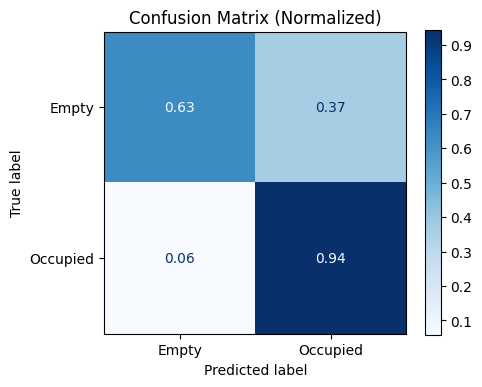

In [47]:
class_names = ["Empty", "Occupied"]

labels, preds = get_predictions(model, val_loader, device)

plot_confusion_matrix(labels, preds, class_names)

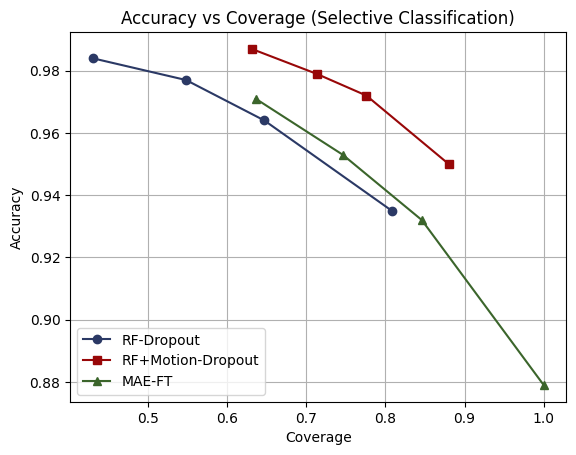

In [48]:
import matplotlib.pyplot as plt

cover_mae = [0.636, 0.746, 0.846, 1.0]
acc_mae   = [0.971, 0.953, 0.932, 0.879]

cover_rf  = [0.430, 0.548, 0.647, 0.808]
acc_rf    = [0.984, 0.977, 0.964, 0.935]

cover_rfm = [0.631, 0.713, 0.776, 0.880]
acc_rfm   = [0.987, 0.979, 0.972, 0.950]

plt.plot(cover_rf,  acc_rf,  'o-', color='#2B3965', label='RF-Dropout')        # blue
plt.plot(cover_rfm, acc_rfm, 's-', color='#980708', label='RF+Motion-Dropout') # red
plt.plot(cover_mae, acc_mae, '^-', color='#3B652B', label='MAE-FT')            # green

plt.xlabel('Coverage')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Coverage (Selective Classification)')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# motion_feats: [N, 500, 4] from compute_motion_features(rf_windows)

import torch
from torch.utils.data import Dataset, DataLoader, random_split

# Convert motion-only features to torch
X_mot = torch.from_numpy(motion_feats).float()  # [N, 500, 4]
y_occ = torch.from_numpy(occ_labels).long()
y_act = torch.from_numpy(act_labels).long()

print("X_mot:", X_mot.shape, " y_occ:", y_occ.shape, " y_act:", y_act.shape)

class WiSAMotionOnlyDataset(Dataset):
    """
    Motion-only dataset using 4 motion features per time step:
      f1: var amplitude
      f2: short-time energy
      f3: |grad mean amplitude|
      f4: |grad STE|
    """
    def __init__(self, X, y_occ, y_act, task="occupancy"):
        self.X = X              # [N, 500, 4]
        self.y_occ = y_occ
        self.y_act = y_act
        assert task in ["occupancy", "activity"]
        self.task = task

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]  # [500, 4]
        y = self.y_occ[idx] if self.task == "occupancy" else self.y_act[idx]
        return x, y

# Use the same "task" variable as RF-only/RF+Motion
task = "occupancy"   # or "activity" if you want multi-class later

full_mot_ds = WiSAMotionOnlyDataset(X_mot, y_occ, y_act, task=task)

N = len(full_mot_ds)
n_train = int(0.8 * N)
n_val   = N - n_train

train_mot_ds, val_mot_ds = random_split(full_mot_ds, [n_train, n_val])

BATCH_SIZE = 64
train_mot_loader = DataLoader(train_mot_ds, batch_size=BATCH_SIZE, shuffle=True)
val_mot_loader   = DataLoader(val_mot_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_mot_ds), len(val_mot_ds)

X_mot: torch.Size([16018, 500, 4])  y_occ: torch.Size([16018])  y_act: torch.Size([16018])


(12814, 3204)

In [50]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score

class MotionOnlyCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Input: [B, 500, 4]  (time, 4 motion features)
        # Treat 4 features as channels
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=128, kernel_size=7, padding=3)
        self.bn1   = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=7, padding=3)
        self.bn2   = nn.BatchNorm1d(256)
        self.pool  = nn.AdaptiveAvgPool1d(1)
        self.fc    = nn.Linear(256, n_classes)

    def forward(self, x):
        # x: [B, 500, 4] → [B, 4, 500]
        x = x.permute(0, 2, 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x).squeeze(-1)   # [B, 256]
        x = self.fc(x)
        return x

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

n_classes = 2 if task == "occupancy" else len(act2id)
mot_model = MotionOnlyCNN(n_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mot_model.parameters(), lr=1e-3)

EPOCHS = 100

for epoch in range(EPOCHS):
    # ---- Train ----
    mot_model.train()
    total_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_mot_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = mot_model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total   += X_batch.size(0)

    train_loss = total_loss / total
    train_acc  = correct / total

    # ---- Validation ----
    mot_model.eval()
    v_correct, v_total = 0, 0
    all_y, all_pred = [], []

    with torch.no_grad():
        for Xv, yv in val_mot_loader:
            Xv, yv = Xv.to(device), yv.to(device)
            logits_v = mot_model(Xv)
            preds_v  = logits_v.argmax(dim=1)

            v_correct += (preds_v == yv).sum().item()
            v_total   += Xv.size(0)

            all_y.append(yv.cpu().numpy())
            all_pred.append(preds_v.cpu().numpy())

    val_acc = v_correct / v_total
    all_y   = np.concatenate(all_y)
    all_pred = np.concatenate(all_pred)

    if task == "occupancy":
        val_f1 = f1_score(all_y, all_pred, average="binary")
    else:
        val_f1 = f1_score(all_y, all_pred, average="macro")

    print(f"[Motion-only] Epoch {epoch+1}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} | "
          f"train_acc={train_acc:.3f} | "
          f"val_acc={val_acc:.3f} | "
          f"val_f1={val_f1:.3f}")

Device: cuda
[Motion-only] Epoch 1/100 | train_loss=0.5977 | train_acc=0.690 | val_acc=0.663 | val_f1=0.762
[Motion-only] Epoch 2/100 | train_loss=0.5771 | train_acc=0.711 | val_acc=0.615 | val_f1=0.758
[Motion-only] Epoch 3/100 | train_loss=0.5711 | train_acc=0.715 | val_acc=0.626 | val_f1=0.757
[Motion-only] Epoch 4/100 | train_loss=0.5670 | train_acc=0.719 | val_acc=0.606 | val_f1=0.755
[Motion-only] Epoch 5/100 | train_loss=0.5587 | train_acc=0.722 | val_acc=0.578 | val_f1=0.661
[Motion-only] Epoch 6/100 | train_loss=0.5501 | train_acc=0.726 | val_acc=0.697 | val_f1=0.740
[Motion-only] Epoch 7/100 | train_loss=0.5410 | train_acc=0.733 | val_acc=0.615 | val_f1=0.758
[Motion-only] Epoch 8/100 | train_loss=0.5322 | train_acc=0.740 | val_acc=0.707 | val_f1=0.718
[Motion-only] Epoch 9/100 | train_loss=0.5245 | train_acc=0.747 | val_acc=0.664 | val_f1=0.656
[Motion-only] Epoch 10/100 | train_loss=0.5194 | train_acc=0.746 | val_acc=0.608 | val_f1=0.755
[Motion-only] Epoch 11/100 | train_l

In [52]:
def mc_dropout_predictions(model, loader, num_mc=20):
    model.train()   # dropout ON
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)

            mc_outputs = []
            for _ in range(num_mc):
                logits = model(X)
                probs = torch.softmax(logits, dim=1)
                mc_outputs.append(probs.unsqueeze(0))  # [1, B, C]

            mc_outputs = torch.cat(mc_outputs, dim=0)  # [num_mc, B, C]
            mean_probs = mc_outputs.mean(dim=0)        # [B, C]

            all_probs.append(mean_probs.cpu())
            all_labels.append(y.cpu())

    all_probs = torch.cat(all_probs, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    return all_probs, all_labels

In [53]:
probs_mot, y_true_mot = mc_dropout_predictions(mot_model, val_mot_loader, num_mc=20)

from scipy.stats import entropy
entropy_mot = entropy(probs_mot, axis=1)
preds_mot   = probs_mot.argmax(axis=1)

def metrics_at_threshold_mot(th):
    keep = entropy_mot < th
    if keep.sum() == 0:
        return None
    acc = (preds_mot[keep] == y_true_mot[keep]).mean()
    coverage = keep.mean()
    return acc, coverage

for th in [0.15, 0.25, 0.35, 0.45, 0.55]:
    res = metrics_at_threshold_mot(th)
    if res is not None:
        print(f"[Motion-only] TH={th:.2f} → Accuracy={res[0]:.3f}, Coverage={res[1]:.3f}")
    else:
        print(f"[Motion-only] TH={th:.2f} → No samples accepted")

[Motion-only] TH=0.15 → Accuracy=0.975, Coverage=0.086
[Motion-only] TH=0.25 → Accuracy=0.955, Coverage=0.196
[Motion-only] TH=0.35 → Accuracy=0.931, Coverage=0.323
[Motion-only] TH=0.45 → Accuracy=0.908, Coverage=0.463
[Motion-only] TH=0.55 → Accuracy=0.889, Coverage=0.615


In [54]:
class MotionOnlyCNNDropout(nn.Module):
    def __init__(self, n_classes, p_drop=0.3):
        super().__init__()
        # Input: [B, 500, 4]
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=128, kernel_size=7, padding=3)
        self.bn1   = nn.BatchNorm1d(128)

        self.conv2 = nn.Conv1d(128, 256, kernel_size=7, padding=3)
        self.bn2   = nn.BatchNorm1d(256)

        # Dropout for regularization + MC uncertainty
        self.drop1 = nn.Dropout(p_drop)
        self.drop2 = nn.Dropout(p_drop)

        self.pool  = nn.AdaptiveAvgPool1d(1)
        self.fc    = nn.Linear(256, n_classes)

    def forward(self, x):
        # x: [B, 500, 4] → [B, 4, 500]
        x = x.permute(0, 2, 1)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.drop1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x).squeeze(-1)  # [B, 256]

        x = self.drop2(x)
        x = self.fc(x)
        return x

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

n_classes_mot = 2 if task == "occupancy" else len(act2id)
mot_do_model = MotionOnlyCNNDropout(n_classes=n_classes_mot, p_drop=0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mot_do_model.parameters(), lr=1e-3)

EPOCHS = 100
best_val_f1 = 0.0
best_state = None
best_epoch = -1

for epoch in range(EPOCHS):
    # ---------- TRAIN ----------
    mot_do_model.train()
    total_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_mot_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = mot_do_model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total   += X_batch.size(0)

    train_loss = total_loss / total
    train_acc  = correct / total

    # ---------- VAL ----------
    mot_do_model.eval()
    v_correct, v_total = 0, 0
    all_y, all_pred = [], []

    with torch.no_grad():
        for Xv, yv in val_mot_loader:
            Xv, yv = Xv.to(device), yv.to(device)
            logits_v = mot_do_model(Xv)
            preds_v  = logits_v.argmax(dim=1)

            v_correct += (preds_v == yv).sum().item()
            v_total   += Xv.size(0)

            all_y.append(yv.cpu().numpy())
            all_pred.append(preds_v.cpu().numpy())

    val_acc = v_correct / v_total
    all_y   = np.concatenate(all_y)
    all_pred = np.concatenate(all_pred)

    if task == "occupancy":
        val_f1 = f1_score(all_y, all_pred, average="binary")
    else:
        val_f1 = f1_score(all_y, all_pred, average="macro")

    # track best
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch + 1
        best_state = mot_do_model.state_dict()
        print(f" New best Motion+Dropout at epoch {best_epoch}: val_f1={best_val_f1:.3f}")

    print(f"[Motion+Dropout] Epoch {epoch+1}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} | "
          f"train_acc={train_acc:.3f} | "
          f"val_acc={val_acc:.3f} | "
          f"val_f1={val_f1:.3f}")

torch.save(best_state, "motion_only_dropout_best.pt")
print("Best Motion+Dropout epoch:", best_epoch, "F1:", best_val_f1)

Device: cuda
🔥 New best Motion+Dropout at epoch 1: val_f1=0.759
[Motion+Dropout] Epoch 1/100 | train_loss=0.6071 | train_acc=0.679 | val_acc=0.622 | val_f1=0.759
🔥 New best Motion+Dropout at epoch 2: val_f1=0.765
[Motion+Dropout] Epoch 2/100 | train_loss=0.5822 | train_acc=0.705 | val_acc=0.663 | val_f1=0.765
[Motion+Dropout] Epoch 3/100 | train_loss=0.5748 | train_acc=0.713 | val_acc=0.652 | val_f1=0.743
[Motion+Dropout] Epoch 4/100 | train_loss=0.5698 | train_acc=0.720 | val_acc=0.612 | val_f1=0.756
[Motion+Dropout] Epoch 5/100 | train_loss=0.5640 | train_acc=0.718 | val_acc=0.612 | val_f1=0.756
[Motion+Dropout] Epoch 6/100 | train_loss=0.5486 | train_acc=0.736 | val_acc=0.631 | val_f1=0.600
[Motion+Dropout] Epoch 7/100 | train_loss=0.5484 | train_acc=0.733 | val_acc=0.606 | val_f1=0.751
[Motion+Dropout] Epoch 8/100 | train_loss=0.5326 | train_acc=0.741 | val_acc=0.635 | val_f1=0.754
[Motion+Dropout] Epoch 9/100 | train_loss=0.5299 | train_acc=0.743 | val_acc=0.623 | val_f1=0.762
🔥 N

In [56]:
def mc_dropout_predictions(model, loader, num_mc=20):
    model.train()   # keep dropout ON
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)

            mc_outputs = []
            for _ in range(num_mc):
                logits = model(X)
                probs = torch.softmax(logits, dim=1)
                mc_outputs.append(probs.unsqueeze(0))  # [1, B, C]

            mc_outputs = torch.cat(mc_outputs, dim=0)  # [num_mc, B, C]
            mean_probs = mc_outputs.mean(dim=0)        # [B, C]

            all_probs.append(mean_probs.cpu())
            all_labels.append(y.cpu())

    all_probs = torch.cat(all_probs, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    return all_probs, all_labels

In [57]:
from scipy.stats import entropy

# load best weights
mot_do_model.load_state_dict(torch.load("motion_only_dropout_best.pt"))
mot_do_model.to(device)

probs_mot_do, y_true_mot_do = mc_dropout_predictions(mot_do_model, val_mot_loader, num_mc=20)

entropy_mot_do = entropy(probs_mot_do, axis=1)
preds_mot_do   = probs_mot_do.argmax(axis=1)

def metrics_at_threshold(ent, preds, labels, th):
    keep = ent < th
    if keep.sum() == 0:
        return None
    acc = (preds[keep] == labels[keep]).mean()
    coverage = keep.mean()
    return acc, coverage

for th in [0.17, 0.35, 0.52, 0.69]:
    res = metrics_at_threshold(entropy_mot_do, preds_mot_do, y_true_mot_do, th)
    if res is not None:
        print(f"[Motion+Dropout] TH={th:.2f} → Accuracy={res[0]:.3f}, Coverage={res[1]:.3f}")
    else:
        print(f"[Motion+Dropout] TH={th:.2f} → No samples accepted")

[Motion+Dropout] TH=0.17 → Accuracy=0.960, Coverage=0.086
[Motion+Dropout] TH=0.35 → Accuracy=0.942, Coverage=0.290
[Motion+Dropout] TH=0.52 → Accuracy=0.898, Coverage=0.544
[Motion+Dropout] TH=0.69 → Accuracy=0.807, Coverage=0.938


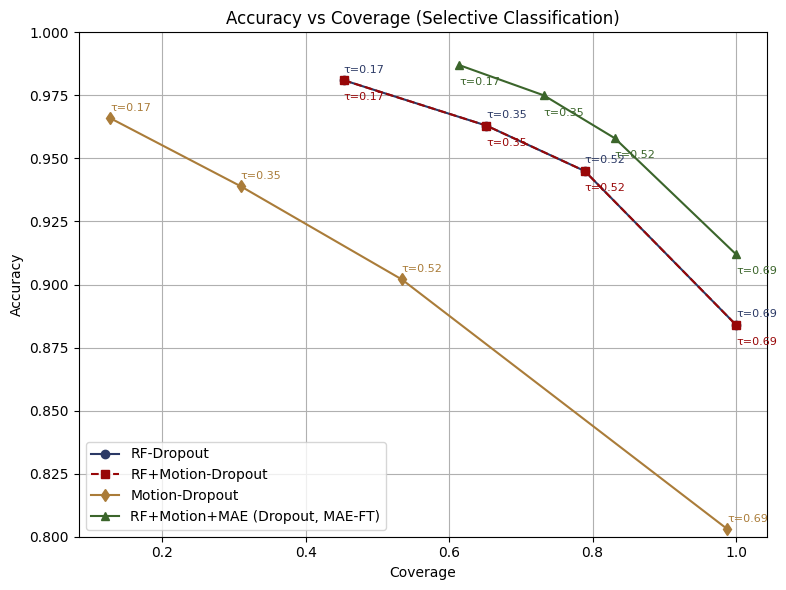

In [58]:
import matplotlib.pyplot as plt

# ---------- Data ----------
thresholds = [0.17, 0.35, 0.52, 0.69]

# Motion-only (with dropout)
cover_mot = [0.127, 0.309, 0.534, 0.988]
acc_mot   = [0.966, 0.939, 0.902, 0.803]

# RF+Motionwith dropout (MAE-FT)
cover_mae = [0.614, 0.732, 0.831, 1.0]
acc_mae   = [0.987, 0.975, 0.958, 0.912]

# RF (with dropout)
cover_rf  = [0.453, 0.652, 0.789, 1.0]
acc_rf    = [0.981, 0.963, 0.945, 0.884]

# RF+Motion uses same numbers as RF
cover_rfm = cover_rf
acc_rfm   = acc_rf

# ---------- Plot ----------
plt.figure(figsize=(8, 6))

# RF
plt.plot(cover_rf, acc_rf, 'o-', color='#2B3965', label='RF-Dropout')
for i, t in enumerate(thresholds):
    plt.text(cover_rf[i], acc_rf[i]+0.003, f"τ={t}", fontsize=8, color='#2B3965')

# RF+Motion
plt.plot(cover_rfm, acc_rfm, 's--', color='#980708', label='RF+Motion-Dropout')
for i, t in enumerate(thresholds):
    plt.text(cover_rfm[i], acc_rfm[i]-0.008, f"τ={t}", fontsize=8, color='#980708')

# Motion-only
plt.plot(cover_mot, acc_mot, 'd-', color='#AA7C39', label='Motion-Dropout')
for i, t in enumerate(thresholds):
    plt.text(cover_mot[i], acc_mot[i]+0.003, f"τ={t}", fontsize=8, color='#AA7C39')

# MAE
plt.plot(cover_mae, acc_mae, '^-', color='#3B652B', label='RF+Motion+MAE (Dropout, MAE-FT)')
for i, t in enumerate(thresholds):
    plt.text(cover_mae[i], acc_mae[i]-0.008, f"τ={t}", fontsize=8, color='#3B652B')

plt.xlabel('Coverage')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Coverage (Selective Classification)')
plt.ylim(0.80, 1.00)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()